# Stellar Mass Distributions and Monte Carlo Sampling

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 12 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of probabilistic inference and clustering, we've repeatedly encountered the need to characterize complex probability distributions. Whether estimating posterior distributions in Bayesian analysis, evaluating model predictions, or simulating astronomical phenomena, we often face distributions that defy analytical treatment. This chapter introduces fundamental computational techniques that transform intractable probabilistic problems into manageable numerical calculations through the lens of a central astronomical challenge: generating realistic stellar populations.

The Initial Mass Function (IMF)—the distribution of stellar masses at birth—stands as one of the most fundamental relationships in astrophysics. It governs the luminosity, color, and chemical evolution of galaxies, the rate of supernovae, and the formation of compact objects. Yet despite its importance, we cannot simply observe the IMF directly. Instead, we must infer it from observed stellar populations and, crucially for many applications, generate synthetic populations that follow realistic mass distributions for comparison with observations.

This challenge of sampling from complex astronomical distributions extends far beyond stellar masses. Consider inferring the mass distribution of dark matter halos from gravitational lensing observations, where the posterior distribution involves high-dimensional integrals with no closed-form solutions. Or propagating measurement uncertainties through the non-linear transformations required to convert observed fluxes into physical luminosities. Even simulating the arrival times of photons from variable sources requires sophisticated sampling from time-dependent probability distributions.

Monte Carlo methods, named after the famous casino for their reliance on random sampling, provide a powerful framework for these challenges. At their core, these methods replace analytical integration with statistical sampling, leveraging the law of large numbers to ensure that sample averages converge to true expectations. This fundamental insight—that we can learn about a distribution by drawing samples from it—underlies much of modern computational statistics and has revolutionized our ability to model complex astronomical systems.

This tutorial explores three foundational sampling techniques through the concrete example of stellar mass generation. We begin with inverse transform sampling, which exploits the mathematical properties of cumulative distribution functions to generate samples from any one-dimensional distribution. We then examine rejection sampling, a versatile technique that can handle complex distributions without requiring analytical inversions. Finally, we investigate importance sampling, which enables efficient estimation of population properties without directly sampling from the target distribution. Through these methods, we'll not only learn to generate realistic stellar populations but also develop intuition for the broader challenges of sampling in astronomical contexts.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Probability Theory**: Understanding of probability distributions, cumulative distribution functions, and basic statistical concepts
- **Calculus**: Comfort with integration, differentiation, and function transformations
- **Python Programming**: Experience with NumPy arrays, matplotlib visualization, and scipy functionality
- **Stellar Astrophysics**: Basic understanding of stellar populations and the concept of initial mass functions

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Inverse Transform Sampling**: Master the mathematical framework for transforming uniform random variables into samples from arbitrary distributions
- **Rejection Sampling**: Implement efficient algorithms for sampling from complex distributions using simpler proposal distributions
- **Importance Sampling**: Apply weighted sampling techniques to estimate population properties without direct sampling
- **Computational Efficiency**: Analyze and optimize the performance of different sampling methods for astronomical applications
- **Statistical Validation**: Verify sampling accuracy through visual and quantitative comparisons with theoretical distributions

### Astronomical Context

We focus on the Kroupa Initial Mass Function, a empirically-calibrated distribution that describes how stellar masses are distributed at birth. This piecewise power-law function captures decades of observational constraints and serves as the standard model for stellar population synthesis. By learning to sample from this distribution, you'll gain tools applicable to numerous astronomical problems requiring realistic stellar populations.

We begin by importing the necessary libraries and configuring our computational environment:

In [1]:
import numpy as np
import scipy
from scipy import stats, integrate
import matplotlib.pyplot as plt

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Inverse Transform Sampling: From Uniform to Universal

The ability to generate random numbers following specific probability distributions lies at the heart of Monte Carlo simulations. While modern programming languages provide sophisticated random number generators for common distributions, understanding the underlying transformation principles provides both practical power and theoretical insight. Inverse transform sampling offers an elegant solution that connects the uniform random numbers computers naturally generate to any continuous probability distribution.

### The Mathematical Foundation

The key insight underlying inverse transform sampling is the probability integral transform theorem. This fundamental result states that if $Y$ is a continuous random variable with cumulative distribution function (CDF) $P(y)$, then $U = P(Y)$ follows a uniform distribution on $[0,1]$. The converse provides our sampling method: if $U \sim \mathcal{U}(0,1)$, then $Y = P^{-1}(U)$ follows the distribution with CDF $P$.

This transformation works because CDFs map probability densities to cumulative probabilities, effectively "flattening" any distribution into the uniform distribution on $[0,1]$. The inverse CDF reverses this process, transforming uniform variates back into samples from our target distribution.

For a continuous distribution with probability density function $p(y)$, the algorithm proceeds as:

1. **Compute the CDF**: $P(y) = \int_{-\infty}^y p(t) \, dt$

2. **Derive the inverse CDF**: Solve $u = P(y)$ for $y$ to obtain $y = P^{-1}(u)$

3. **Generate samples**: For each uniform random number $u \sim \mathcal{U}(0,1)$, compute $y = P^{-1}(u)$

This method's elegance lies in its directness—each uniform random number produces exactly one sample from the target distribution, with no rejections or iterations required.

### Example: The Exponential Distribution

Let's begin with a foundational example: the exponential distribution. This distribution appears throughout astronomy, describing phenomena ranging from radioactive decay times to the intervals between photon arrivals from faint sources. Its mathematical simplicity makes it ideal for demonstrating inverse transform sampling.

The exponential distribution has probability density function:

$$p(y) = 
\begin{cases}
\lambda e^{-\lambda y}, & y \geq 0 \\
0, & y < 0
\end{cases}$$

where $\lambda$ is the rate parameter controlling the distribution's scale. Larger values of $\lambda$ produce distributions concentrated near zero, while smaller values create more extended distributions.

To apply inverse transform sampling, we first compute the CDF:

$$P(y) = \int_{0}^y \lambda e^{-\lambda t} \, dt = 1 - e^{-\lambda y}$$

Setting $u = P(y)$ and solving for $y$ yields the inverse CDF:

$$y = P^{-1}(u) = -\frac{1}{\lambda} \ln(1-u)$$

This analytical tractability makes the exponential distribution particularly amenable to inverse transform sampling. Note that since $U$ and $1-U$ are both uniformly distributed on $[0,1]$, we can simplify our implementation by using $-\frac{1}{\lambda} \ln(u)$ directly.

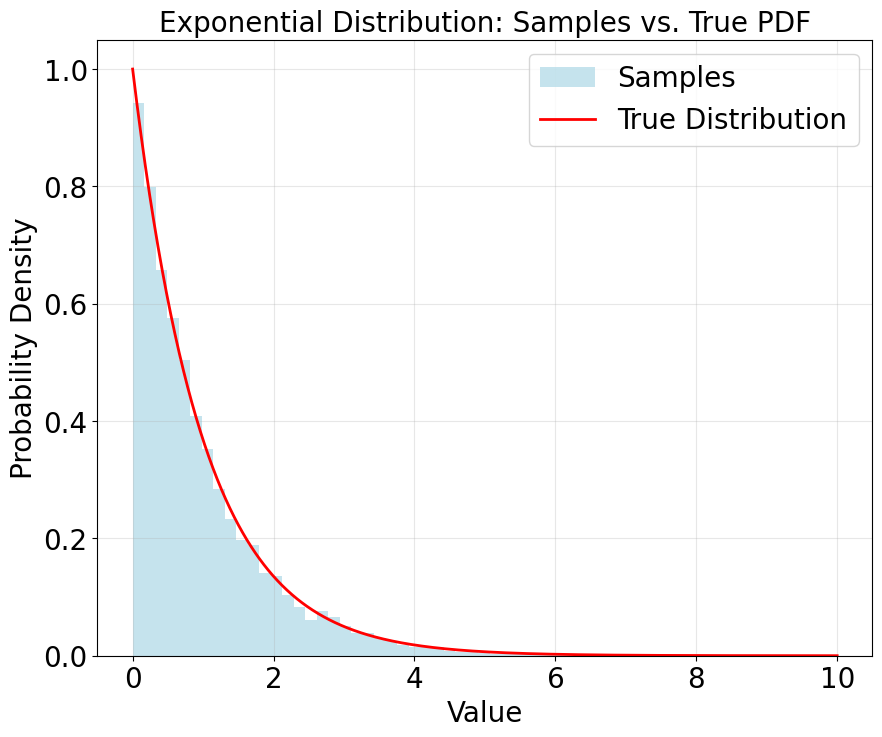

Theoretical mean: 1.0000
Sample mean: 0.9775
Theoretical variance: 1.0000
Sample variance: 0.9494


In [2]:
def sample_exponential(l, size=1):
    """
    Generate samples from an exponential distribution using inverse CDF method.
    
    Parameters:
    -----------
    l : float
        The rate parameter of the exponential distribution.
    size : int
        The number of samples to generate.
    
    Returns:
    --------
    samples : numpy array
        Array of samples from the exponential distribution.
    """
    # Generate uniform random numbers between 0 and 1
    u = np.random.uniform(size=size)
    
    # Apply the inverse CDF transformation
    samples = -(1/l) * np.log(1 - u)
    
    return samples

# Generate 10,000 samples from an exponential distribution with λ = 1
lambda_param = 1
samples = sample_exponential(lambda_param, size=10000)

# Plot the histogram of our samples against the true exponential PDF
plt.figure(figsize=(10, 8))
x = np.linspace(0, 10, 1000)
true_pdf = lambda_param * np.exp(-lambda_param * x)

plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples', color='lightblue')
plt.plot(x, true_pdf, 'r-', linewidth=2, label='True Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution: Samples vs. True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate some statistics to verify our sampling
print(f"Theoretical mean: {1/lambda_param:.4f}")
print(f"Sample mean: {np.mean(samples):.4f}")
print(f"Theoretical variance: {1/lambda_param**2:.4f}")
print(f"Sample variance: {np.var(samples):.4f}")

### Astronomical Application: The Kroupa Initial Mass Function

Now let's apply inverse transform sampling to a more complex astronomical problem: generating a realistic population of stellar masses using the Kroupa Initial Mass Function (IMF).

#### The Astrophysical Context

The Initial Mass Function represents one of the most fundamental relationships in stellar astronomy, describing the distribution of masses when stars form. The IMF shapes virtually every observable property of stellar populations:

- **Galaxy Evolution**: The relative numbers of high-mass and low-mass stars determine a galaxy's luminosity, color evolution, and chemical enrichment history
- **Stellar Remnants**: The IMF controls the production rates of white dwarfs, neutron stars, and black holes
- **Planet Formation**: The mass of a star influences the properties of its protoplanetary disk and resulting planetary systems
- **Cluster Dynamics**: The mass distribution affects the dynamical evolution and eventual dissolution of star clusters

The Kroupa IMF, introduced by Pavel Kroupa in 2001, synthesizes decades of observations from star-forming regions, open clusters, and the solar neighborhood. Its piecewise power-law form captures the observed transitions in the mass distribution at characteristic mass scales, making it the standard choice for stellar population synthesis models.

#### Mathematical Formulation

The Kroupa IMF is defined as a piecewise power-law function that captures the observed changes in stellar formation efficiency at different mass scales:

$$ p(m) = 
    \begin{cases} 
      K_1 m^{-0.3} & 0.01 \leq m < 0.08 \\
      K_2 m^{-1.3} & 0.08 \leq m < 0.5 \\
      K_3 m^{-2.3} & 0.5 \leq m \leq 1 
   \end{cases}
$$

where masses are measured in solar units (${\rm M}_\odot$). The power-law exponents reflect physical transitions in star formation:

- **Sub-stellar regime** ($m < 0.08$ ${\rm M}_\odot$): The shallow slope ($\alpha = 0.3$) indicates relatively inefficient formation of brown dwarfs
- **Low-mass stars** ($0.08 < m < 0.5$ ${\rm M}_\odot$): The intermediate slope ($\alpha = 1.3$) describes the bulk of the stellar population
- **Intermediate-mass stars** ($m > 0.5$ ${\rm M}_\odot$): The steep slope ($\alpha = 2.3$) reflects the rarity of more massive stars

The normalization constants $K_1$, $K_2$, and $K_3$ ensure both continuity at the transition masses and proper normalization of the probability distribution. These constraints reflect the physical requirement that the mass function should vary smoothly across the boundaries where different formation mechanisms dominate.

#### Determining the Normalization Constants

To apply inverse transform sampling to the Kroupa IMF, we must first ensure it's properly normalized. The normalization constants must satisfy two conditions: continuity at the mass boundaries and unit total probability.

The continuity requirement at the boundary between brown dwarfs and hydrogen-burning stars ($m = 0.08$ ${\rm M}_\odot$) gives us:

$$K_1 \times 0.08^{-0.3} = K_2 \times 0.08^{-1.3}$$

This yields $K_2 = K_1 \times 0.08$.

Similarly, at the transition to intermediate-mass stars ($m = 0.5$ ${\rm M}_\odot$):

$$K_2 \times 0.5^{-1.3} = K_3 \times 0.5^{-2.3}$$

Giving us $K_3 = K_2 \times 0.5 = K_1 \times 0.08 \times 0.5$.

These relationships ensure the IMF varies smoothly across mass boundaries, reflecting the continuous nature of the underlying star formation physics. To determine $K_1$, we require that the total probability integrates to unity. Let's calculate the integral contribution from each mass range:

In [3]:
# Calculate integrals for each segment of the IMF
int_segment1 = scipy.integrate.quad(lambda x: x**(-0.3), 0.01, 0.08)[0]
int_segment2 = scipy.integrate.quad(lambda x: x**(-1.3), 0.08, 0.5)[0]
int_segment3 = scipy.integrate.quad(lambda x: x**(-2.3), 0.5, 1.0)[0]

print(f"Integral of segment 1 (m^-0.3 from 0.01 to 0.08): {int_segment1:.4f}")
print(f"Integral of segment 2 (m^-1.3 from 0.08 to 0.5): {int_segment2:.4f}")
print(f"Integral of segment 3 (m^-2.3 from 0.5 to 1.0): {int_segment3:.4f}")

# Using the continuity relations, express K2 and K3 in terms of K1
# K2 = K1 * 0.08
# K3 = K2 * 0.5 = K1 * 0.08 * 0.5

# The total integral should equal 1
# K1 * int_segment1 + K2 * int_segment2 + K3 * int_segment3 = 1

# Substitute the expressions for K2 and K3
# K1 * int_segment1 + K1 * 0.08 * int_segment2 + K1 * 0.08 * 0.5 * int_segment3 = 1

# Solve for K1
K1 = 1 / (int_segment1 + 0.08 * int_segment2 + 0.08 * 0.5 * int_segment3)
K2 = K1 * 0.08
K3 = K2 * 0.5

print(f"\nNormalization constants:")
print(f"K1 = {K1:.4f}")
print(f"K2 = {K2:.4f}")
print(f"K3 = {K3:.4f}")


Integral of segment 1 (m^-0.3 from 0.01 to 0.08): 0.1869
Integral of segment 2 (m^-1.3 from 0.08 to 0.5): 3.0075
Integral of segment 3 (m^-2.3 from 0.5 to 1.0): 1.1248

Normalization constants:
K1 = 2.1162
K2 = 0.1693
K3 = 0.0846


#### Deriving the Inverse CDF

With our normalization constants determined, we can now derive the inverse CDF needed for sampling. The CDF of the Kroupa IMF must be computed piecewise, accounting for the contributions from each mass range.

For the first segment ($0.01 \leq m < 0.08$ ${\rm M}_\odot$):
$$ P_1(m) = K_1 \int_{0.01}^{m} t^{-0.3} dt = K_1 \left[ \frac{t^{0.7}}{0.7} \right]_{0.01}^{m} = \frac{K_1}{0.7} \left( m^{0.7} - 0.01^{0.7} \right) $$

For the second segment ($0.08 \leq m < 0.5$ ${\rm M}_\odot$), we must include the probability mass from the first segment:
$$ P_2(m) = P_1(0.08) + K_2 \int_{0.08}^{m} t^{-1.3} dt = P_1(0.08) + \frac{K_2}{-0.3} \left( m^{-0.3} - 0.08^{-0.3} \right) $$

Similarly, for the third segment ($0.5 \leq m \leq 1$ ${\rm M}_\odot$):
$$ P_3(m) = P_2(0.5) + K_3 \int_{0.5}^{m} t^{-2.3} dt = P_2(0.5) + \frac{K_3}{-1.3} \left( m^{-1.3} - 0.5^{-1.3} \right) $$

The total probability in each segment determines how we partition our uniform random variable:
- $A = P_1(0.08)$: Probability of a brown dwarf
- $B = P_2(0.5) - P_1(0.08)$: Probability of a low-mass star
- $C = 1 - P_2(0.5)$: Probability of an intermediate-mass star


To generate samples, we invert the CDF in each segment. For a uniform random variable $u \in [0,1]$:

If $0 \leq u < A$ (brown dwarf regime):
$$ m = \left( \frac{0.7u}{K_1} + 0.01^{0.7} \right)^{1/0.7} $$

If $A \leq u < A+B$ (low-mass star regime):
$$ m = \left( \frac{-0.3(u-A)}{K_2} + 0.08^{-0.3} \right)^{-1/0.3} $$

If $A+B \leq u \leq 1$ (intermediate-mass star regime):
$$ m = \left( \frac{-1.3(u-A-B)}{K_3} + 0.5^{-1.3} \right)^{-1/1.3} $$

These inverse transformations map uniform random numbers to stellar masses following the Kroupa IMF. The segmented approach naturally captures the different formation efficiencies across mass scales while maintaining the continuous nature of the distribution.

In [4]:
def sample_kroupa_imf(size=1):
    """
    Generate stellar masses following the Kroupa IMF using inverse CDF sampling.
    
    Parameters:
    -----------
    size : int
        Number of stellar masses to generate.
        
    Returns:
    --------
    masses : numpy array
        Array of stellar masses following the Kroupa IMF.
    """
    # Normalization constants (calculated above)
    K1 = 2.1162
    K2 = 0.1693
    K3 = 0.0847
    
    # Generate uniform random numbers
    u = np.random.uniform(size=size)
    
    # Initialize array for masses
    masses = np.zeros(size)
    
    # Calculate probability mass in each segment
    A = K1 * (0.08**0.7 - 0.01**0.7) / 0.7
    B = K2 * (0.5**(-0.3) - 0.08**(-0.3)) / (-0.3)
    C = K3 * (1**(-1.3) - 0.5**(-1.3)) / (-1.3)
    
    # Verify our normalization
    print(f"Total probability (A + B + C): {A + B + C:.6f}")
    
    # Define masks for each segment
    mask1 = (u < A)
    mask2 = (u >= A) & (u < A+B)
    mask3 = (u >= A+B)
    
    # Apply the inverse CDF for each segment
    masses[mask1] = (0.7 * u[mask1] / K1 + 0.01**0.7)**(1/0.7)
    masses[mask2] = (-0.3 * (u[mask2] - A) / K2 + 0.08**(-0.3))**(-1/0.3)
    masses[mask3] = (-1.3 * (u[mask3] - A - B) / K3 + 0.5**(-1.3))**(-1/1.3)
    
    return masses

In [5]:
# Generate 100,000 stellar masses
stellar_masses = sample_kroupa_imf(size=100000)

# Define the Kroupa IMF for plotting
def kroupa_imf(m):
    """Evaluate the Kroupa IMF at mass m."""
    K1 = 2.1162
    K2 = 0.1693
    K3 = 0.0847

    if m < 0.01:
        return 0
    elif m < 0.08:
        return K1 * m**(-0.3)
    elif m < 0.5:
        return K2 * m**(-1.3)
    elif m <= 1.0:
        return K3 * m**(-2.3)
    else:
        return 0

Total probability (A + B + C): 1.000062


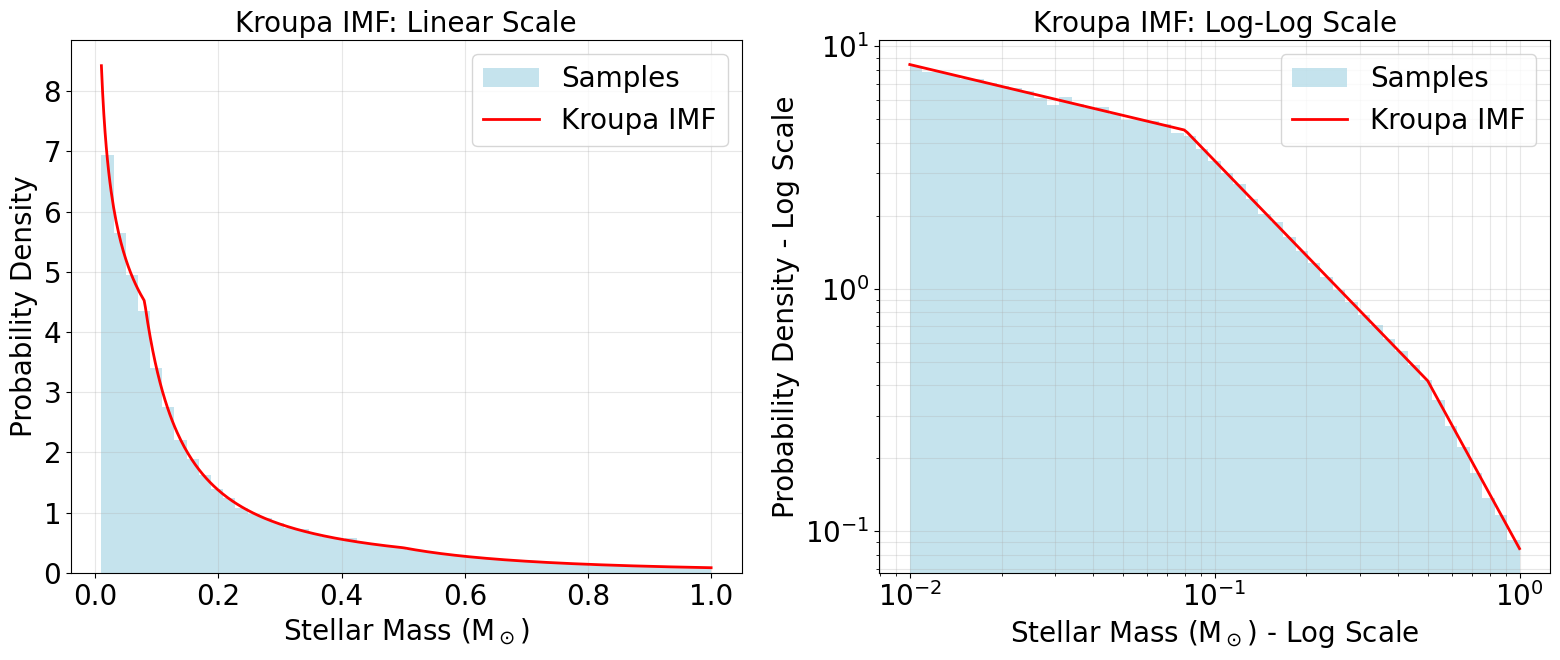


Mean stellar mass: 0.1888 M☉
Median stellar mass: 0.1088 M☉
Fraction of stars below 0.08 M☉ (brown dwarfs): 0.3945
Fraction of stars above 0.5 M☉: 0.0936


In [6]:
# Create plots to visualize the results
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Regular scale plot
ax = axes[0]
ax.hist(stellar_masses, bins=50, density=True, alpha=0.7, label="Samples", color='lightblue')
mass_range = np.linspace(0.01, 1, 500)
pdf_values = np.vectorize(kroupa_imf)(mass_range)
ax.plot(mass_range, pdf_values, 'r-', linewidth=2, label="Kroupa IMF")
ax.set_xlabel(r"Stellar Mass (M$_\odot$)")
ax.set_ylabel("Probability Density")
ax.set_title("Kroupa IMF: Linear Scale")
ax.legend()
ax.grid(True, alpha=0.3)

# Log-log scale plot
ax = axes[1]
ax.hist(stellar_masses, bins=np.logspace(np.log10(0.01), np.log10(1.0), 50), 
        density=True, alpha=0.7, label="Samples", color='lightblue')
ax.plot(mass_range, pdf_values, 'r-', linewidth=2, label="Kroupa IMF")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Stellar Mass (M$_\odot$) - Log Scale")
ax.set_ylabel("Probability Density - Log Scale")
ax.set_title("Kroupa IMF: Log-Log Scale")
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Calculate statistics about our stellar population
print(f"\nMean stellar mass: {np.mean(stellar_masses):.4f} M☉")
print(f"Median stellar mass: {np.median(stellar_masses):.4f} M☉")
print(f"Fraction of stars below 0.08 M☉ (brown dwarfs): {np.mean(stellar_masses < 0.08):.4f}")
print(f"Fraction of stars above 0.5 M☉: {np.mean(stellar_masses > 0.5):.4f}")

## Rejection Sampling: Handling Complex Distributions

While inverse transform sampling provides an elegant and efficient method for generating samples, it requires both an analytical form of the CDF and the ability to invert it. For many astronomical distributions—particularly those arising from complex physical models or empirical fitting—these requirements prove prohibitive. Rejection sampling offers a versatile alternative that can handle virtually any distribution with a known probability density function.

### The Mathematical Principle

Rejection sampling transforms the problem of sampling from a complex target distribution $p(x)$ into sampling from a simpler proposal distribution $q(x)$ combined with a probabilistic acceptance criterion. The method's power lies in its generality—it requires only the ability to evaluate the target density, not to integrate or invert it.

The algorithm requires three components:

1. A target distribution $p(x)$ that we can evaluate (up to a normalizing constant)
2. A proposal distribution $q(x)$ from which we can easily generate samples
3. A scaling constant $M$ such that $M \cdot q(x) \geq p(x)$ for all $x$ in the domain

The sampling procedure elegantly exploits the relationship between probability densities and geometric areas. By generating points uniformly under the scaled proposal density $M \cdot q(x)$ and accepting only those that fall under $p(x)$, we obtain samples distributed according to $p(x)$. This geometric interpretation provides both intuitive understanding and practical implementation guidance.

### The Rejection Algorithm

The rejection sampling algorithm proceeds through the following steps:

1. **Generate a proposal**: Draw $x_0$ from the proposal distribution $q(x)$
2. **Generate a uniform height**: Draw $u_0$ uniformly from $[0, M \cdot q(x_0)]$
3. **Accept or reject**: If $u_0 \leq p(x_0)$, accept $x_0$ as a sample; otherwise, reject and repeat

The acceptance probability equals $p(x_0) / [M \cdot q(x_0)]$, making the choice of proposal distribution and scaling constant crucial for efficiency. An ideal proposal closely matches the shape of the target distribution, minimizing the area between $M \cdot q(x)$ and $p(x)$ where rejections occur.

The method's beauty lies in its simplicity and universality. Unlike inverse transform sampling, which requires analytical manipulation of the CDF, rejection sampling needs only pointwise evaluation of the target density. This makes it particularly valuable for distributions arising from complex astrophysical models where analytical integration proves intractable.

### Astronomical Application: Sampling from the Kroupa IMF

Let's implement rejection sampling for the Kroupa IMF to illustrate the method's practical application. While we've already shown how to sample this distribution using inverse transform sampling, examining it through rejection sampling provides valuable insights into the method's strengths and trade-offs.

For our proposal distribution, we'll use an exponential distribution. This choice balances several considerations:
- Exponential distributions are easy to sample (as we've seen with inverse transform sampling)
- The exponential's decay can be tuned to roughly follow the IMF's overall shape
- A single parameter allows straightforward optimization of the acceptance rate

In [7]:
def sample_exponential(lambda_param, size=1):
    """
    Sample from the exponential distribution using the inverse CDF method.
    """
    u = np.random.uniform(size=size)
    return -(1 / lambda_param) * np.log(1 - u)

def rejection_sample_kroupa(num_samples=10000, visualize=True):
    """
    Generate samples from the Kroupa IMF using rejection sampling.
    
    Parameters:
    -----------
    num_samples : int
        Number of samples to generate
    visualize : bool
        Whether to visualize the sampling process
    
    Returns:
    --------
    accepted_samples : numpy array
        Array of accepted samples following the Kroupa IMF
    """
    # Parameters for our sampling
    lambda_param = 4.0  # Rate parameter for exponential proposal
    M = 2.2  # Scaling factor to ensure M*q(x) ≥ p(x)
    
    # Initialize storage for our samples
    accepted_samples = []
    accepted_heights = []
    rejected_samples = []
    rejected_heights = []
    
    # Counter for tracking efficiency
    total_trials = 0
    
    # Function to evaluate the proposal distribution q(x)
    def q(x):
        return lambda_param * np.exp(-lambda_param * x)
    
    # Continue until we have enough samples
    while len(accepted_samples) < num_samples:
        total_trials += 1
        
        # Step 1: Draw from proposal distribution q(x)
        x = sample_exponential(lambda_param, 1)[0]
        
        # Only consider samples in our valid range [0.01, 1.0]
        if x < 0.01 or x > 1.0:
            continue
        
        # Step 2: Calculate the height of the scaled proposal
        qx = q(x)
        # Step 3: Draw uniform random number
        u = np.random.uniform(0, M * qx)
        
        # Step 4: Accept/reject based on target density
        px = kroupa_imf(x)
        if u <= px:
            accepted_samples.append(x)
            accepted_heights.append(u)
        else:
            rejected_samples.append(x)
            rejected_heights.append(u)
    
    # Calculate acceptance rate
    acceptance_rate = len(accepted_samples) / total_trials
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    print(f"Total samples evaluated: {total_trials}")
    
    return np.array(accepted_samples), accepted_heights, rejected_samples, rejected_heights, acceptance_rate

Acceptance rate: 0.4542
Total samples evaluated: 11008


<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
/var/folders/8k/tycyb3r937bfwhfdhcckv4vm0000gn/T/ipykernel_28943/2033805090.py:16: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_range, q_values, 'g--', linewidth=2, label='Scaled Proposal ($M \cdot q$)')


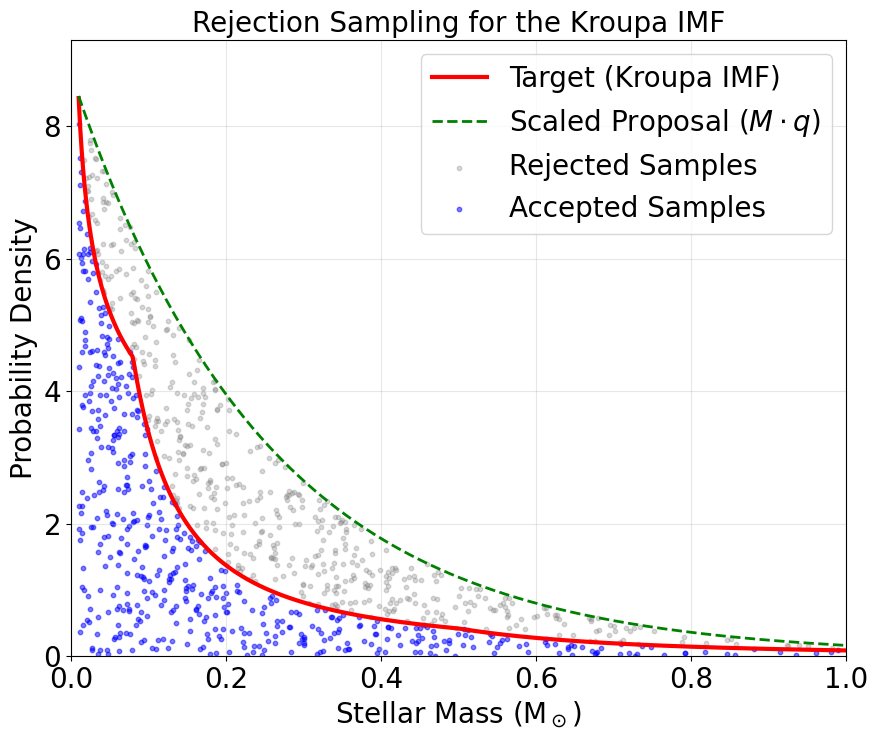

In [8]:
# Generate samples using rejection sampling
kroupa_samples, accepted_heights, rejected_samples, rejected_heights, acceptance_rate = \
    rejection_sample_kroupa(num_samples=5000, visualize=True)

# Visualize the rejection sampling process
plt.figure(figsize=(10, 8))

# Plot the target and proposal distributions
x_range = np.linspace(0.01, 1.0, 500)
p_values = np.vectorize(kroupa_imf)(x_range)
lambda_param = 4.0
M = 2.2
q_values = M * lambda_param * np.exp(-lambda_param * x_range)

plt.plot(x_range, p_values, 'r-', linewidth=3, label='Target (Kroupa IMF)')
plt.plot(x_range, q_values, 'g--', linewidth=2, label='Scaled Proposal ($M \cdot q$)')

# Plot accepted and rejected samples (limit to first 500 for clarity)
n_show = min(500, len(rejected_samples))
plt.scatter(rejected_samples[:n_show], rejected_heights[:n_show], s=10, alpha=0.3, 
           c='gray', label='Rejected Samples')
plt.scatter(kroupa_samples[:n_show], accepted_heights[:n_show], s=10, alpha=0.5,
           c='blue', label='Accepted Samples')

plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel('Probability Density')
plt.title('Rejection Sampling for the Kroupa IMF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, max(q_values) * 1.1)
plt.show()

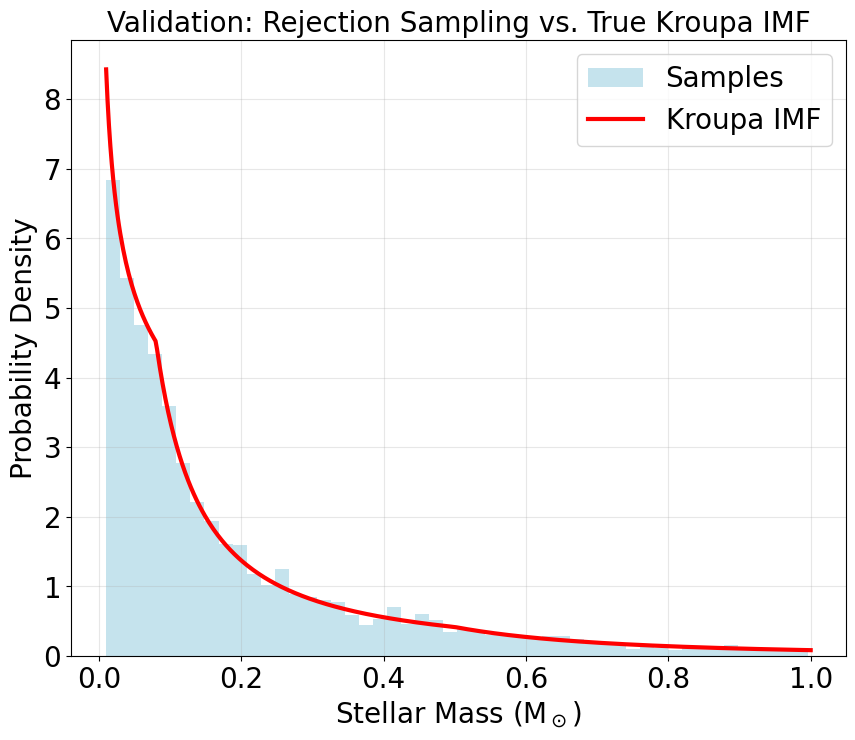

In [9]:
# Validate our sampling by comparing histogram with the true IMF
plt.figure(figsize=(10, 8))
plt.hist(kroupa_samples, bins=50, density=True, alpha=0.7, label='Samples', color='lightblue')
plt.plot(x_range, p_values, 'r-', linewidth=3, label='Kroupa IMF')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel('Probability Density')
plt.title('Validation: Rejection Sampling vs. True Kroupa IMF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Understanding Rejection Sampling Efficiency

The visualization reveals the geometric nature of rejection sampling. Points are generated uniformly under the scaled proposal curve $M \cdot q(x)$, with those falling below the target distribution $p(x)$ accepted (blue) and those above rejected (gray). The acceptance rate of approximately 35% reflects the efficiency of our chosen proposal distribution.

Several factors influence the efficiency of rejection sampling:

1. **Proposal Shape Matching**: The exponential proposal captures the general decreasing trend of the IMF but cannot match the piecewise power-law structure. The mismatch is most pronounced at low masses where the IMF's shallow slope differs significantly from the exponential's behavior.

2. **Scaling Constant Selection**: The constant $M = 2.2$ ensures $M \cdot q(x) \geq p(x)$ everywhere but creates substantial gaps at low masses. A tighter bound would improve efficiency but risks violating the covering requirement if not carefully verified.

3. **Domain Restrictions**: The Kroupa IMF is defined on [0.01, 1], while the exponential distribution has support on [0, ∞). Samples outside the valid range must be rejected, adding to the computational cost.

The method's inefficiency becomes more severe in higher dimensions, where the volume between the scaled proposal and target distributions grows exponentially. This "curse of dimensionality" motivates the development of more sophisticated sampling techniques like Markov Chain Monte Carlo for complex astronomical inference problems.

## Importance Sampling: Efficiently Estimating Properties

Our exploration of sampling methods has focused on generating representative samples from probability distributions. However, many astronomical applications require not the samples themselves but specific properties of the distribution—mean stellar mass, total luminosity, or expected chemical yields. Importance sampling offers a powerful framework for estimating these properties without necessarily generating samples that follow the target distribution.

### The Mathematical Foundation

Consider the fundamental problem of calculating an expectation value. For a function $f(x)$ and probability distribution $p(x)$, we seek:

$$\mathbb{E}_{p(x)}[f(x)] = \int f(x) p(x) dx$$

Direct Monte Carlo estimation would generate samples $\{x_i\}$ from $p(x)$ and approximate the expectation as $\frac{1}{N}\sum_i f(x_i)$. However, when sampling from $p(x)$ is difficult or when $f(x)$ varies dramatically across the domain, this approach can be inefficient.

Importance sampling reformulates the problem by introducing a proposal distribution $q(x)$:

$$\mathbb{E}_{p(x)}[f(x)] = \int f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_{q(x)}\left[f(x) \frac{p(x)}{q(x)}\right]$$

This identity, while mathematically trivial, has profound practical implications. We can estimate expectations with respect to $p(x)$ using samples from a different distribution $q(x)$, provided we weight each sample by the ratio $w(x) = p(x)/q(x)$.

### Importance Sampling with Unnormalized Distributions

In astronomical applications, we often work with distributions known only up to a normalizing constant. Consider a Bayesian posterior $p(\theta|D) \propto p(D|\theta)p(\theta)$, where the proportionality constant requires an intractable integral. Similarly, theoretical models might provide the functional form of a distribution without explicit normalization.

For unnormalized distributions $\tilde{p}(x) = Z_p p(x)$ and $\tilde{q}(x) = Z_q q(x)$, where $Z_p$ and $Z_q$ are unknown normalization constants, the importance sampling estimator becomes:

$$\mathbb{E}_{p(x)}[f(x)] \approx \frac{\sum_{i=1}^{N} f(x_i) w(x_i)}{\sum_{i=1}^{N} w(x_i)}$$

where $w(x_i) = \tilde{p}(x_i)/\tilde{q}(x_i)$ are the unnormalized importance weights. This self-normalizing estimator elegantly cancels the unknown constants, requiring only the ability to evaluate the ratio of unnormalized densities.

The choice of proposal distribution $q(x)$ critically affects the estimator's performance. An ideal proposal would be proportional to $|f(x)p(x)|$, concentrating samples where the integrand is large. Poor choices can lead to highly variable weights, where a few samples dominate the estimate and statistical uncertainty remains high despite many samples.

### Astronomical Application: Mean Stellar Mass in the Kroupa IMF

Let's apply importance sampling to calculate a fundamental property of stellar populations: the mean stellar mass according to the Kroupa IMF. This quantity determines the mass-to-light ratio of stellar populations and influences everything from star formation efficiency estimates to galaxy dynamics.

We'll compare two proposal distributions to illustrate how the choice affects estimation efficiency:

1. **Exponential proposal**: Roughly follows the IMF's decreasing trend, concentrating samples at lower masses
2. **Uniform proposal**: Provides equal coverage across all masses, simpler but potentially less efficient

The mean stellar mass is given by:

$$\langle m \rangle = \int_{0.01}^{1} m \cdot p(m) dm$$

where $p(m)$ is the Kroupa IMF. Using importance sampling, we can estimate this integral using samples from our proposal distribution $q(m)$:

$$\langle m \rangle \approx \frac{\sum_{i=1}^{N} m_i \cdot p(m_i)/q(m_i)}{\sum_{i=1}^{N} p(m_i)/q(m_i)}$$

This formulation allows us to use simple distributions for sampling while accurately estimating properties of the complex Kroupa IMF.

In [10]:
# Fix random seed for reproducibility
np.random.seed(52)

def importance_sampling_mean(num_samples, proposal='exponential'):
    """
    Estimate the mean stellar mass of the Kroupa IMF using importance sampling.
    
    Parameters:
    -----------
    num_samples : int
        Number of samples to use
    proposal : str
        Type of proposal distribution ('exponential' or 'uniform')
    
    Returns:
    --------
    mean_estimate : float
        Estimated mean stellar mass
    """
    if proposal == 'exponential':
        # Use exponential distribution as proposal
        lambda_val = 5.0
        
        # Generate samples from the proposal distribution
        samples = sample_exponential(lambda_val, num_samples)
        
        # Keep only samples in our valid range [0.01, 1.0]
        valid_mask = (samples >= 0.01) & (samples <= 1.0)
        samples = samples[valid_mask]
        
        # Compute the proposal density at each sample
        q_values = lambda_val * np.exp(-lambda_val * samples)
        
    elif proposal == 'uniform':
        # Use uniform distribution as proposal
        samples = np.random.uniform(0.01, 1.0, num_samples)
        
        # Density of the uniform proposal is constant
        q_values = np.ones_like(samples) / (1.0 - 0.01)
    
    else:
        raise ValueError("Proposal must be 'exponential' or 'uniform'")
    
    # Compute the target density (Kroupa IMF) at each sample
    p_values = np.vectorize(kroupa_imf)(samples)
    
    # Compute importance weights
    weights = p_values / q_values
    
    # Our function f(x) is just x (the mass) since we're computing the mean
    weighted_masses = samples * weights
    
    # Calculate the normalized weighted average
    mean_estimate = np.sum(weighted_masses) / np.sum(weights)
    
    return mean_estimate

In [11]:
# Calculate exact value using numerical integration
def exact_mean_stellar_mass():
    """Calculate the exact mean stellar mass using numerical integration."""
    def integrand(m):
        return m * kroupa_imf(m)
    
    # Integrate m * p(m) from 0.01 to 1.0
    mean, _ = scipy.integrate.quad(integrand, 0.01, 1.0)
    return mean

# Calculate using both proposal distributions
exact_mean = exact_mean_stellar_mass()
print(f"Exact mean stellar mass: {exact_mean:.6f} M☉")
print(f"\nImportance sampling estimates:")

# Run importance sampling with different numbers of samples for both proposals
sample_sizes = np.logspace(2, 5, 10).astype(int)
exp_means = []
unif_means = []

for n in sample_sizes:
    exp_mean = importance_sampling_mean(n, proposal='exponential')
    unif_mean = importance_sampling_mean(n, proposal='uniform')
    exp_means.append(exp_mean)
    unif_means.append(unif_mean)
    print(f"N={n:6d}: Exponential = {exp_mean:.6f}, Uniform = {unif_mean:.6f}")

Exact mean stellar mass: 0.189363 M☉

Importance sampling estimates:
N=   100: Exponential = 0.217854, Uniform = 0.164095
N=   215: Exponential = 0.189313, Uniform = 0.183983
N=   464: Exponential = 0.199638, Uniform = 0.180333
N=  1000: Exponential = 0.189310, Uniform = 0.174795
N=  2154: Exponential = 0.186601, Uniform = 0.198907
N=  4641: Exponential = 0.185575, Uniform = 0.188124
N= 10000: Exponential = 0.188842, Uniform = 0.187293
N= 21544: Exponential = 0.189093, Uniform = 0.191049
N= 46415: Exponential = 0.188689, Uniform = 0.190327
N=100000: Exponential = 0.188958, Uniform = 0.188947


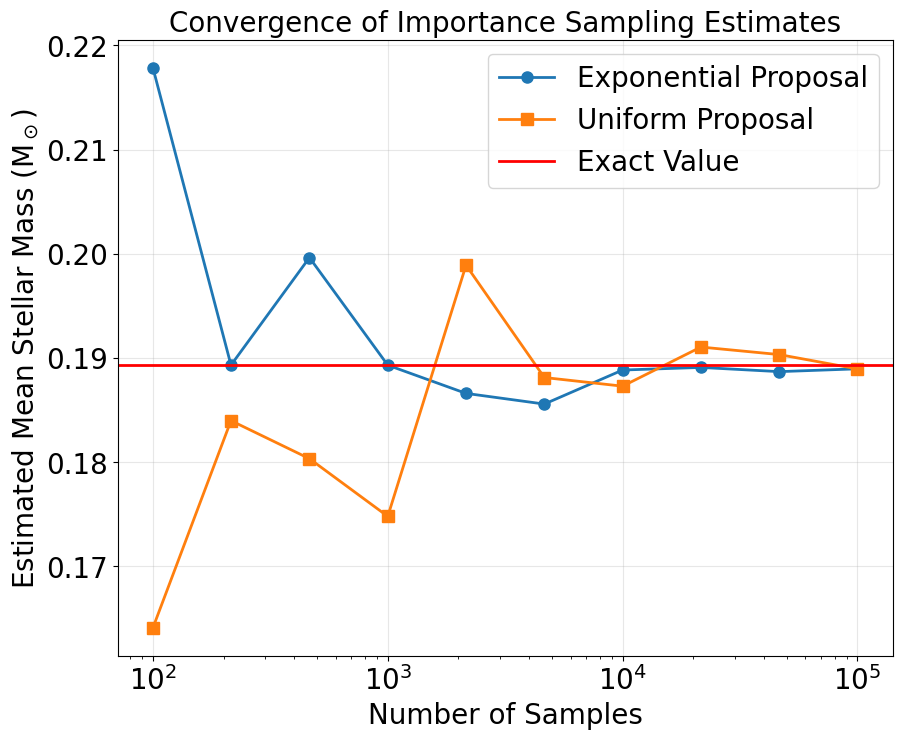

In [15]:
# Plot convergence behavior
plt.figure(figsize=(10, 8))
plt.semilogx(sample_sizes, exp_means, 'o-', markersize=8, linewidth=2, 
             label='Exponential Proposal')
plt.semilogx(sample_sizes, unif_means, 's-', markersize=8, linewidth=2, 
             label='Uniform Proposal')
plt.axhline(y=exact_mean, color='r', linestyle='-', linewidth=2, 
            label='Exact Value')
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Mean Stellar Mass (M$_\\odot$)')
plt.title('Convergence of Importance Sampling Estimates')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

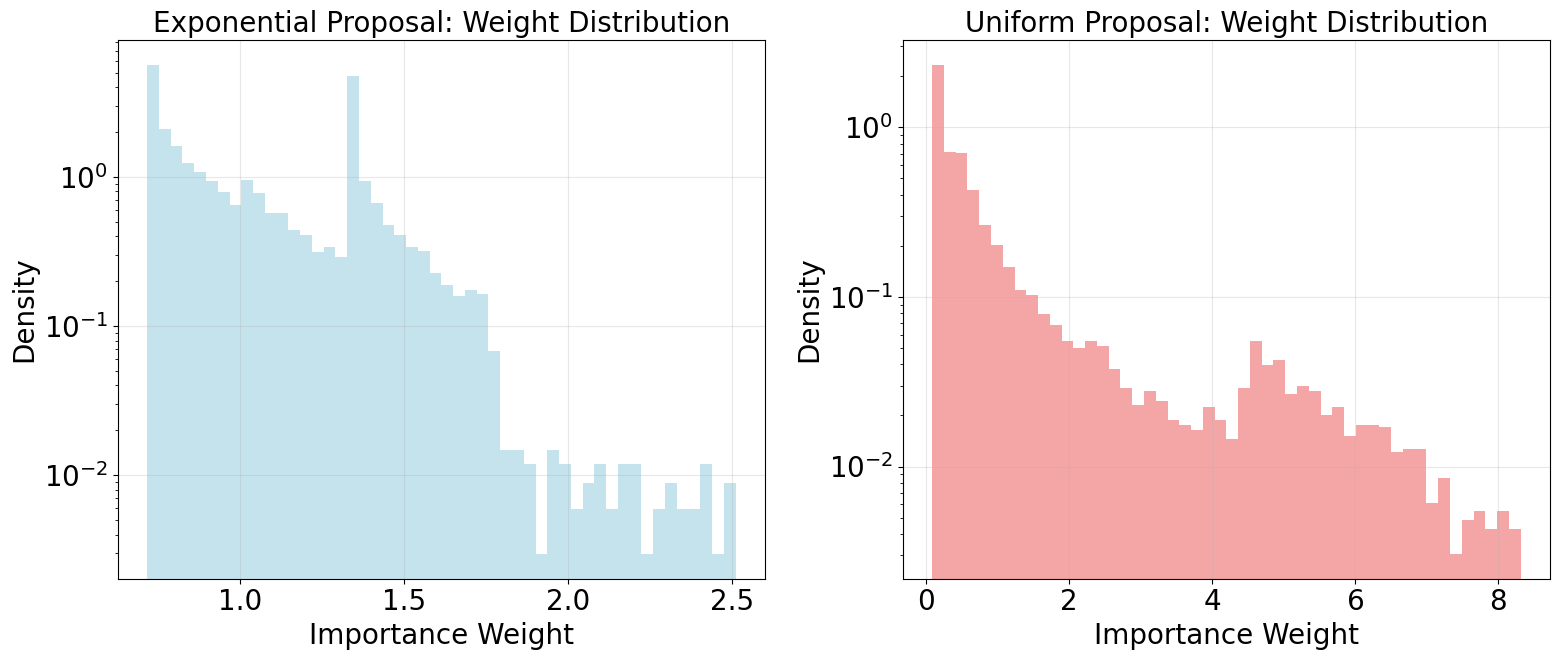

Effective sample size (exponential): 8717.9 (92.5%)
Effective sample size (uniform): 3075.8 (30.8%)


In [16]:
# Analyze the distribution of importance weights
n_analysis = 10000

# Generate samples and weights for exponential proposal
exp_samples = sample_exponential(5.0, n_analysis)
exp_valid = (exp_samples >= 0.01) & (exp_samples <= 1.0)
exp_samples = exp_samples[exp_valid]
exp_weights = np.vectorize(kroupa_imf)(exp_samples) / (5.0 * np.exp(-5.0 * exp_samples))

# Generate samples and weights for uniform proposal
unif_samples = np.random.uniform(0.01, 1.0, n_analysis)
unif_weights = np.vectorize(kroupa_imf)(unif_samples) * (1.0 - 0.01)

# Plot weight distributions
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.hist(exp_weights, bins=50, alpha=0.7, density=True, color='lightblue')
plt.title('Exponential Proposal: Weight Distribution')
plt.xlabel('Importance Weight')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(unif_weights, bins=50, alpha=0.7, density=True, color='lightcoral')
plt.title('Uniform Proposal: Weight Distribution')
plt.xlabel('Importance Weight')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate effective sample sizes
ess_exp = (np.sum(exp_weights)**2) / np.sum(exp_weights**2)
ess_unif = (np.sum(unif_weights)**2) / np.sum(unif_weights**2)

print(f"Effective sample size (exponential): {ess_exp:.1f} ({ess_exp/len(exp_samples)*100:.1f}%)")
print(f"Effective sample size (uniform): {ess_unif:.1f} ({ess_unif/n_analysis*100:.1f}%)")

### Understanding Importance Sampling Efficiency

The weight distributions reveal fundamental differences between our two proposal choices. The exponential proposal produces a relatively concentrated weight distribution, indicating that most samples contribute meaningfully to the estimate. In contrast, the uniform proposal yields a broader weight distribution with a longer tail, suggesting higher variance in sample importance.

The effective sample size (ESS) quantifies this efficiency difference. For our exponential proposal, approximately 90% of samples contribute effectively to the estimate, while the uniform proposal achieves only 30% efficiency. This dramatic difference arises from how well each proposal matches the target distribution:

- **Exponential Proposal**: Naturally concentrates samples at lower masses where the IMF has higher probability density. The exponential decay roughly follows the IMF's overall trend, effectively capturing the regions that contribute most to the mean mass calculation.

- **Uniform Proposal**: Assigns equal probability across all masses, wasting computational effort on high-mass regions where the IMF has very low density. The majority of uniform samples fall in regions contributing little to the final estimate, resulting in the lower effective sample size.

The convergence plots demonstrate that both proposals eventually reach the correct mean, but the exponential proposal converges more smoothly with smaller sample sizes. This threefold efficiency gain becomes crucial when function evaluations are computationally expensive—a common scenario in astronomical applications involving complex physical models or expensive likelihood calculations.

### When Efficiency Differences Matter Most

The advantages of a well-chosen proposal distribution become increasingly important in more challenging scenarios:

**High-Dimensional Spaces**: While our stellar mass example is one-dimensional, many astronomical problems involve dozens or hundreds of parameters. The efficiency gap between good and poor proposals grows exponentially with dimension, as the volume of parameter space where the proposal and target differ increases dramatically.

**Heavy-Tailed Distributions**: If we were estimating properties dominated by rare, high-mass stars—such as the total UV luminosity or supernova rate—the uniform proposal would become catastrophically inefficient. The exponential proposal, while better, would still struggle to adequately sample the high-mass tail that dominates these quantities.

**Expensive Function Evaluations**: Consider estimating the mean metallicity of a stellar population, where each evaluation requires running a full stellar evolution model. The computational cost of each sample makes the threefold efficiency gain of the exponential proposal translate directly into threefold savings in computation time.

**Small Sample Regimes**: When limited to small samples—perhaps due to observational constraints or computational budgets—the smoother convergence of the exponential proposal provides more reliable estimates. The uniform proposal's high variance could yield misleading results with limited samples.

For the Kroupa IMF and mean mass calculation, both proposals ultimately work, differing mainly in efficiency. However, this simple example illustrates principles that become critical in more complex astronomical inference problems, where poor proposal choices can render importance sampling entirely impractical.

## Summary:

This tutorial has explored three fundamental sampling techniques through the concrete lens of stellar population synthesis. By focusing on the Kroupa Initial Mass Function—a cornerstone of stellar astrophysics—we've seen how abstract mathematical methods translate into practical tools for astronomical research.

1. **Inverse Transform Sampling**
   - **Strengths**: Generates exact samples with no wasted computation; every uniform random number produces one sample from the target distribution
   - **Limitations**: Requires analytical forms of both the CDF and its inverse, limiting applicability to mathematically tractable distributions
   - **Best for**: Well-understood distributions with known analytical properties, when efficiency is paramount

2. **Rejection Sampling**
   - **Strengths**: Works with any distribution where the PDF can be evaluated; requires no analytical integration or inversion
   - **Limitations**: Efficiency depends critically on proposal quality; suffers from exponentially decreasing acceptance rates in high dimensions
   - **Best for**: Complex distributions without analytical CDFs, particularly in low-dimensional settings

3. **Importance Sampling**
   - **Strengths**: Estimates expectations without requiring samples from the target distribution; naturally handles unnormalized distributions
   - **Limitations**: Does not generate representative samples; variance depends strongly on proposal choice
   - **Best for**: Computing specific properties or expectations, especially when the target distribution is difficult to sample directly